In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# set terminal options to display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
!pip install -U xlrd

In [4]:
!pip install -U pandas

     |████████████████████████████████| 12.1 MB 2.8 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.4
    Uninstalling pandas-1.3.4:
      Successfully uninstalled pandas-1.3.4


## 1. Dataset
- We are using "default of credit card clients Data Set" from UCI Machine Learning Repository
- This dataset consists of customers' default payments (fail to pay the credit card by the due date) data in Taiwan among six data mining methods
- Binary dependent variable "default payment next month" (1 = default, 0 = not default)
- Detailed attributes descriptions [here](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

In [5]:
import pandas as pd
from sklearn.metrics import roc_curve, auc

pd.set_option('display.max_columns', 100)

df = pd.read_excel('http://fengmai.net//download/courses/2020S-BIA652NT-Pub/Week10-Classification%20and%20Hyperparameter%20Search%20using%20Python/default%20of%20credit%20card%20clients.xls', header = 1).drop('ID', axis = 1)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
# basic data exploration
df.shape
df.columns
df.isnull().values.any()

(30000, 24)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

False

In [7]:
df.describe().T.to_excel("desc_stats.xlsx")

In [8]:
df['default payment next month'].value_counts()
# note that this is an imbalanced dataset, we should look at the confusion matrix rather than overall accuracy (will be discussed later).

0    23364
1     6636
Name: default payment next month, dtype: int64

<AxesSubplot:xlabel='default payment next month', ylabel='count'>

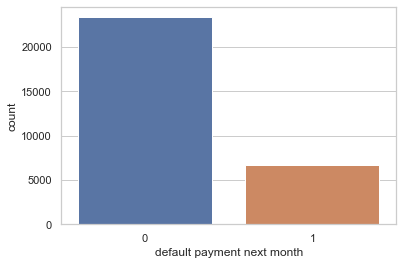

In [9]:
import seaborn as sns
sns.set(style = 'whitegrid')
sns.countplot(data = df, x = 'default payment next month')

## 2. Creating Dummy Variables (One-Hot Encoding)
- Many machine learning algorithms cannot work with categorical data directly. Thus, categorical data must be converted to numbers (dummy variables), e.g., "cold": 1, "warm": 2, "hot": 3
- Yet, there may still be problems when there is no ordinal relationship and allowing the representation to lean on any such relationship might be damaging to learning to solve the problem, e.g. "dog": 1, "cat": 2. In these cases, we would like to give the model more expressive power to learn a probability-like number for each possible label value
- One Hot Encoding: a representation of categorical variables as binary vectors
    - first requires that the categorical values be mapped to integer values
    - each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1
- More details [here](https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/)

In [10]:
df.apply(lambda col: len(col.unique()))
# in our case, ['SEX', 'EDUCATION', 'MARRIAGE'] are dummy variables

LIMIT_BAL                        81
SEX                               2
EDUCATION                         7
MARRIAGE                          4
AGE                              56
PAY_0                            11
PAY_2                            11
PAY_3                            11
PAY_4                            11
PAY_5                            10
PAY_6                            10
BILL_AMT1                     22723
BILL_AMT2                     22346
BILL_AMT3                     22026
BILL_AMT4                     21548
BILL_AMT5                     21010
BILL_AMT6                     20604
PAY_AMT1                       7943
PAY_AMT2                       7899
PAY_AMT3                       7518
PAY_AMT4                       6937
PAY_AMT5                       6897
PAY_AMT6                       6939
default payment next month        2
dtype: int64

In [11]:
col = ['SEX', 'EDUCATION', 'MARRIAGE']
df2 = pd.get_dummies(df, columns = col, drop_first=True)
df2.head()
df2.shape

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0
1,120000,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1,0,1,0,0,0,0,0,1,0
2,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,1,0,1,0,0,0,0,0,1,0
3,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,0,1,0,0,0,0,1,0,0
4,50000,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0,0,1,0,0,0,0,1,0,0


(30000, 31)

## 3. Logistic Regression

In [12]:
import statsmodels.api as sm

logit_mod = sm.Logit(df2['default payment next month'], sm.add_constant((df2.drop('default payment next month', axis = 1))))
logit_res = logit_mod.fit()
print(logit_res.summary())

         Current function value: 0.463788
         Iterations: 35
                               Logit Regression Results                               
Dep. Variable:     default payment next month   No. Observations:                30000
Model:                                  Logit   Df Residuals:                    29969
Method:                                   MLE   Df Model:                           30
Date:                        Mon, 12 Dec 2022   Pseudo R-squ.:                  0.1223
Time:                                14:49:35   Log-Likelihood:                -13914.
converged:                              False   LL-Null:                       -15853.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -15.9136    552.196     -0.029      0.977   -1098.198    1066.37

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
to_drop = []
corr_matrix = sm.add_constant((df2.drop('default payment next month', axis = 1))).corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (corr_matrix.iloc[i, j] >= 0.80) and i != j:
            print(f"{corr_matrix.columns[i]} and {corr_matrix.index[j]} have a correlation of {corr_matrix.iloc[i, j]}" ) 
            to_drop.append(corr_matrix.index[j])

PAY_5 and PAY_4 have a correlation of 0.8198353114868158
PAY_6 and PAY_5 have a correlation of 0.8169001604176753
BILL_AMT2 and BILL_AMT1 have a correlation of 0.9514836727518136
BILL_AMT3 and BILL_AMT1 have a correlation of 0.8922785291271761
BILL_AMT3 and BILL_AMT2 have a correlation of 0.9283262592714855
BILL_AMT4 and BILL_AMT1 have a correlation of 0.8602721890293095
BILL_AMT4 and BILL_AMT2 have a correlation of 0.8924822912577209
BILL_AMT4 and BILL_AMT3 have a correlation of 0.9239694565909823
BILL_AMT5 and BILL_AMT1 have a correlation of 0.8297786058330013
BILL_AMT5 and BILL_AMT2 have a correlation of 0.859778307271445
BILL_AMT5 and BILL_AMT3 have a correlation of 0.8839096973620155
BILL_AMT5 and BILL_AMT4 have a correlation of 0.9401344040880004
BILL_AMT6 and BILL_AMT1 have a correlation of 0.8026501885528455
BILL_AMT6 and BILL_AMT2 have a correlation of 0.8315935591018213
BILL_AMT6 and BILL_AMT3 have a correlation of 0.8533200905940468
BILL_AMT6 and BILL_AMT4 have a correlation

In [14]:
to_drop

['PAY_4',
 'PAY_5',
 'BILL_AMT1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5']

In [15]:
import statsmodels.api as sm

logit_mod = sm.Logit(df2['default payment next month'], sm.add_constant((df2.drop(['default payment next month'] + to_drop, axis = 1))))
logit_res = logit_mod.fit(maxiter = 1000)
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.464704
         Iterations 67
                               Logit Regression Results                               
Dep. Variable:     default payment next month   No. Observations:                30000
Model:                                  Logit   Df Residuals:                    29976
Method:                                   MLE   Df Model:                           23
Date:                        Mon, 12 Dec 2022   Pseudo R-squ.:                  0.1206
Time:                                14:49:52   Log-Likelihood:                -13941.
converged:                               True   LL-Null:                       -15853.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -475.0167        nan        

In [16]:
log_sum = logit_res.summary()

In [17]:
log_sum.as_csv()

'                         Logit Regression Results                         \nDep. Variable:  ,default payment next month,  No. Observations:  , 30000  \nModel:          ,Logit                     ,  Df Residuals:      , 29976  \nMethod:         ,MLE                       ,  Df Model:          ,    23  \nDate:           ,Mon, 12 Dec 2022          ,  Pseudo R-squ.:     ,0.1206  \nTime:           ,14:49:55                  ,  Log-Likelihood:    , -13941.\nconverged:      ,True                      ,  LL-Null:           , -15853.\nCovariance Type:,nonrobust                 ,  LLR p-value:       , 0.000  \n           ,   coef   , std err ,    z    ,P>|z| ,  [0.025 ,  0.975] \nconst      , -475.0167,      nan,      nan,   nan,      nan,      nan\nLIMIT_BAL  ,-8.539e-07, 1.57e-07,   -5.453, 0.000,-1.16e-06,-5.47e-07\nAGE        ,    0.0053,    0.002,    2.857, 0.004,    0.002,    0.009\nPAY_0      ,    0.5830,    0.018,   32.852, 0.000,    0.548,    0.618\nPAY_2      ,    0.0670,    0.020,   

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)  

**Make sure that you choose the regularization hyperparameter (C) wisely! The default C is 1.0, which can be very detrimental to model performance. Note that C is the inverse of lambda, smaller C means stronger penalty for complicated models. ** In this example, we set C to a large number. 

In [18]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

y = df2['default payment next month']
x = df2.drop('default payment next month', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [19]:
# standardization before fitting data so that they have 0-mean and unit-variance: z = (x - u) / s
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_s = scaler.transform(x_train)
x_test_s = scaler.transform(x_test)

In [20]:
lg = LogisticRegression(C=100, solver = 'lbfgs', max_iter = 1000)
lg.fit(x_train_s, y_train)

LogisticRegression(C=100, max_iter=1000)

In [21]:
y_predict_test = lg.predict(x_test_s)

In [22]:
y_predict_test[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
y_test[:20].values

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

## 4. Performance evaluation
- Accuracy
- Confusion Matrix
- Precision, Recall, and F1-score
- More details [here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)

### 4.1. Accuracy
- Accuracy is often used to measure model performance

In [24]:
lg.score

<bound method ClassifierMixin.score of LogisticRegression(C=100, max_iter=1000)>

In [25]:
print('classifier accuracy is {:.2f}'.format(lg.score(x_test_s, y_test)))

classifier accuracy is 0.82


In [26]:
from sklearn.metrics import accuracy_score
print('classifier accuracy is {:.2f}'.format(accuracy_score(y_true=y_test, y_pred=y_predict_test)))

classifier accuracy is 0.82


- However, for an imbalanced classification problem where **the sample is imbalanced (one category represents the overwhelming majority of the data points)** or **the cost is asymmetric**, accuracy can be a problematic metric
  - prediction of rare diseases
  - mortgage default
  - antibody test

### 4.2. Confusion Matrix
- Two types of prediction errors:
  - False Positive: Predict an event when there was no event
  - False Negative: Predict no event when in fact there was an event

In [27]:
# confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true=y_test, y_pred=y_predict_test)
print('confusion matrix:\n', cm)

confusion matrix:
 [[4607   96]
 [ 983  314]]


In [28]:
tn, fp, fn, tp = cm.ravel()
print(f'tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}')

tn: 4607, fp: 96, fn: 983, tp: 314


<AxesSubplot:>

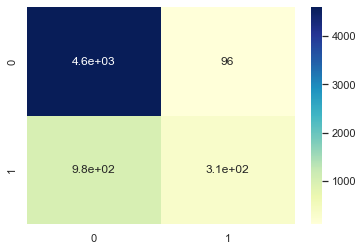

In [29]:
sns.heatmap(pd.DataFrame(cm), annot = True, cmap="YlGnBu")

### 4.3. Precision, Recall, and F1-score
- Precision: precentage of true cases among the predicated true cases
- Recall:  precentage of true cases that have been retrieved over the total number of true cases
    - Metrics: <br>
   $$ 
    \begin{align}
     precision~of~positive~class &= \frac{true~positives}{ true~positives + false~positives} \\
     recall~of~positive~class &= \frac{true~positives}{ true~positives + false~negatives}
    \end{align}
    $$
- F-score: $$\frac{2*precision*recall}{precision+recall}$$

In [30]:
# classification report
print('classification report:\n', classification_report(y_test, y_predict_test))

classification report:
               precision    recall  f1-score   support

           0       0.82      0.98      0.90      4703
           1       0.77      0.24      0.37      1297

    accuracy                           0.82      6000
   macro avg       0.80      0.61      0.63      6000
weighted avg       0.81      0.82      0.78      6000



### 4.4 Decision threshold

By default, most classification algorithms can output a predicted probability using `predict_proba()`. The default decision threshold is $p = 0.5$, meaning if $p(y|x) > 0.5$ then predicted class is 1. Sometimes it is necassary to use a difference decision threshold. 

In [31]:
predict_prob = lg.predict_proba(x_test_s)
# note that the predicted prob has 2 columns and they add up to 1. 
# The columns give the predicted probability of each class.
predict_prob[:5]

array([[0.50724594, 0.49275406],
       [0.75125153, 0.24874847],
       [0.67405048, 0.32594952],
       [0.79626982, 0.20373018],
       [0.94587177, 0.05412823]])

When we set the threshold to 0.1, the recall for y = 1 class goes up, and precision goes down (think about why). This is a fundamental tradeoff that you need to make. The optimal threshold depends on 
- the relative cost between false positive and false negative. 
- how unbalanced the classes are in the train set.

In [32]:
print('classification report:\n', classification_report(y_test, predict_prob[:,1] > 0.1))

classification report:
               precision    recall  f1-score   support

           0       0.90      0.22      0.35      4703
           1       0.24      0.91      0.38      1297

    accuracy                           0.37      6000
   macro avg       0.57      0.56      0.37      6000
weighted avg       0.76      0.37      0.36      6000



## 5. ROC curve and Precision-Recall Curve
- ROC curve and AUC
- Precision-Recall Curve
- More details [here](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

### 5.1 ROC curve and AUC
- **Receiver operating characteristic (ROC) curve** plots the true positive rate (TPR) vs the false positive rate (FPR) as a function of the model’s threshold for classifying positives
- Metrics: <br>

$$ 
    \begin{align}
     true~positive~rate~(tpr) &= recall~of~positive~class  \\
     false~positive~rate~(fpr) &= \frac{false~positives}{ false~positives + true~negatives} \\
     & = 1- recall~of~negative~class
    \end{align}
$$ 

- **Area under the curve (AUC)** is a metric to calculate the overall performance of a classification model based on area under the ROC curve 
- **Important**: To genenrate the ROC curve, you need to use the output from `predict_proba`, not `predict`! The `roc_curve` function automatically varies the decision threshold and computes the TP and FP at any given threshold. 

In [33]:
y_test

8225     0
10794    0
9163     0
26591    0
6631     0
        ..
12715    0
28867    0
3758     1
17842    0
9119     0
Name: default payment next month, Length: 6000, dtype: int64

In [34]:
predict_prob[:, 1]

array([0.49275406, 0.24874847, 0.32594952, ..., 0.232804  , 0.59737045,
       0.27097503])

In [35]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

fpr, tpr, thresholds = roc_curve(y_test, predict_prob[:, 1])
print('AUC: {:.2f}'.format(auc(fpr, tpr)))

AUC: 0.72


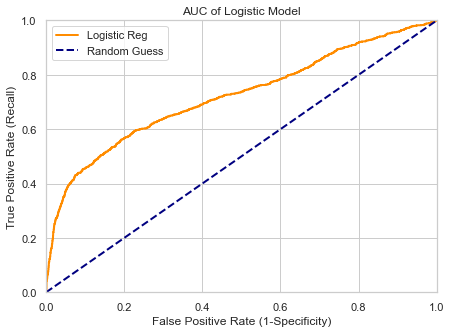

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize = (7, 5))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'Logistic Reg')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--', label = 'Random Guess')
plt.title('AUC of Logistic Model')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Recall)' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()
plt.show();

AUC: 0.61


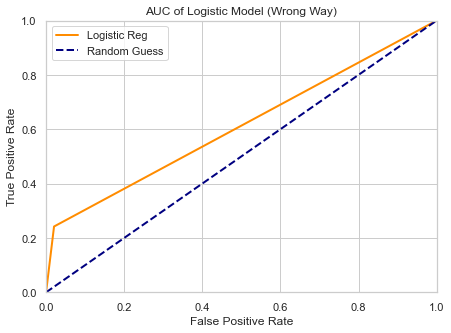

In [37]:
# !!!! Warning! Wrong Approach !!!! #######
fpr, tpr, thresholds = roc_curve(y_test, predict_prob[:, 1] > 0.5)
print('AUC: {:.2f}'.format(auc(fpr, tpr)))

import matplotlib.pyplot as plt
plt.figure(figsize = (7, 5))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'Logistic Reg')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--', label = 'Random Guess')
plt.title('AUC of Logistic Model (Wrong Way)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()
plt.show();

Using the binary classification output instead of predicted probability to construct the ROC curve and to compute AUC is a common mistake. See [SAS's Python API tutorial](https://github.com/sassoftware/saspy-examples/blob/8b5caae91b375276c3d20b2aa62a3fce9ff881f7/SAS_contrib/SASPy%20for%20Machine%20Learning.ipynb)

### 5.2 Precision-Recall Curve
- **Precision-Recall Curve** plots the precision (y-axis) and the recall (x-axis) for different thresholds, much like the ROC curve


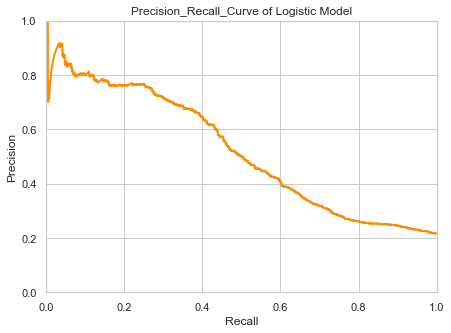

In [38]:
precision, recall, thresholds = precision_recall_curve(y_test, predict_prob[:,1] )

plt.figure(figsize = (7, 5))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision_Recall_Curve of Logistic Model')
plt.show();

Quiz: When decision threshold increases, what happens to the horizontal axis (recall)?

## 6. PCA
- **Principal Component Analysis (PCA)** is a dimension-reduction tool that can be used to reduce a large set of variables to a small set that still contains most of the information in the large set.
- The main purpose of principal component analysis is to:
    - identify hidden pattern in a data set,
    - reduce the dimensionnality of the data by removing the noise and redundancy in the data,
    - deal with multicollinearity

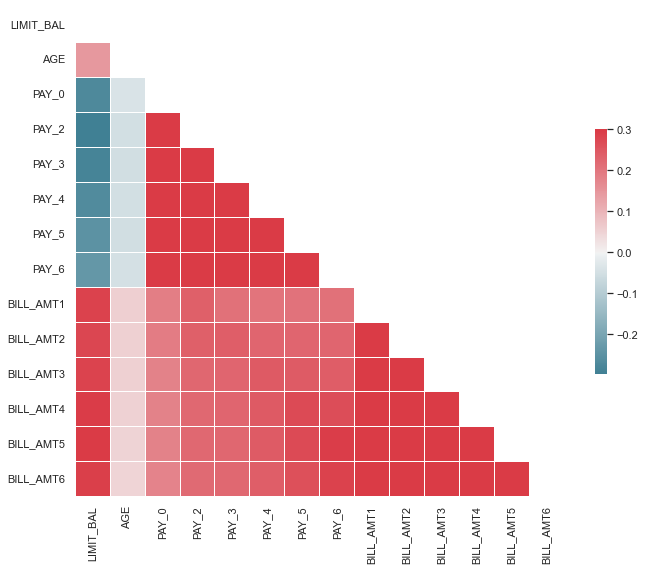

In [39]:
import numpy as np

# correlation matrix
corr = df2.iloc[:, :14].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show();

In [40]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

y = df2['default payment next month'].values.astype(float)
x = df2.drop('default payment next month', axis = 1).values.astype(float)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Note that standardization is important in PCA since the latter projects your original data onto directions which maximize the variance
# If the features have different scales, this projection may get skrewed
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_s = scaler.transform(x_train)
x_test_s = scaler.transform(x_test)

In [41]:
# find the number of principle components which have 80% information of the original dataset
pca = PCA(n_components = 0.8)
pca.fit(x_train_s)
print('Variance ratio of each pc:\n', pca.explained_variance_ratio_, '\n')
print('Explained variance of each pc:\n', pca.explained_variance_, '\n')
print('Selected {} pcs'.format(pca.n_components_))
print('Original dataset shape: ', df2.shape)

PCA(n_components=0.8)

Variance ratio of each pc:
 [0.21799803 0.13913982 0.08078993 0.05517653 0.05156652 0.04100052
 0.03477682 0.03395631 0.0335844  0.03308976 0.03297848 0.03109158
 0.02917485] 

Explained variance of each pc:
 [6.54021343 4.17436855 2.42379879 1.65536501 1.54706001 1.23006684
 1.04334794 1.01873168 1.00757405 0.99273404 0.98939558 0.93278632
 0.87528199] 

Selected 13 pcs
Original dataset shape:  (30000, 31)


In [42]:
x_train_pca = pca.transform(x_train_s)
x_test_pca = pca.transform(x_test_s)

lg = LogisticRegression(C = 1000, solver = 'lbfgs', max_iter = 1000)
lg.fit(x_train_pca, y_train)

predict = lg.predict(x_test_pca)

LogisticRegression(C=1000, max_iter=1000)

In [43]:
from sklearn.metrics import confusion_matrix, classification_report
print('classifier accuracy is {:.2f}'.format(lg.score(x_test_pca, y_test)))

cm = confusion_matrix(y_test, predict)
print('confusion matrix:\n', cm)

print('classification report:\n', classification_report(y_test, predict))

classifier accuracy is 0.81
confusion matrix:
 [[4618   85]
 [1083  214]]
classification report:
               precision    recall  f1-score   support

         0.0       0.81      0.98      0.89      4703
         1.0       0.72      0.16      0.27      1297

    accuracy                           0.81      6000
   macro avg       0.76      0.57      0.58      6000
weighted avg       0.79      0.81      0.75      6000



In [44]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_mod = LinearDiscriminantAnalysis()
lda_mod.fit(x_train_pca, y_train)
predict = lda_mod.predict(x_test_pca)
cm = confusion_matrix(y_test, predict)
print('confusion matrix:\n', cm)
print('classification report:\n', classification_report(y_test, predict))

LinearDiscriminantAnalysis()

confusion matrix:
 [[4600  103]
 [1077  220]]
classification report:
               precision    recall  f1-score   support

         0.0       0.81      0.98      0.89      4703
         1.0       0.68      0.17      0.27      1297

    accuracy                           0.80      6000
   macro avg       0.75      0.57      0.58      6000
weighted avg       0.78      0.80      0.75      6000



In [45]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda_mod = QuadraticDiscriminantAnalysis()
qda_mod.fit(x_train_pca, y_train)
predict = qda_mod.predict(x_test_pca)
cm = confusion_matrix(y_test, predict)
print('confusion matrix:\n', cm)
print('classification report:\n', classification_report(y_test, predict))

QuadraticDiscriminantAnalysis()

confusion matrix:
 [[ 748 3955]
 [  76 1221]]
classification report:
               precision    recall  f1-score   support

         0.0       0.91      0.16      0.27      4703
         1.0       0.24      0.94      0.38      1297

    accuracy                           0.33      6000
   macro avg       0.57      0.55      0.32      6000
weighted avg       0.76      0.33      0.29      6000



In [46]:
qda_mod = QuadraticDiscriminantAnalysis()
qda_mod.fit(x_train_pca, y_train)
predict = qda_mod.predict_proba(x_test_pca)[:, 1] > 0.9
cm = confusion_matrix(y_test, predict)
print('confusion matrix:\n', cm)
print('classification report:\n', classification_report(y_test, predict))

QuadraticDiscriminantAnalysis()

confusion matrix:
 [[4402  301]
 [ 898  399]]
classification report:
               precision    recall  f1-score   support

         0.0       0.83      0.94      0.88      4703
         1.0       0.57      0.31      0.40      1297

    accuracy                           0.80      6000
   macro avg       0.70      0.62      0.64      6000
weighted avg       0.77      0.80      0.78      6000



## Deciding the number of principal components by cross validation
- We can use CV on train set to decide the best number of PC (2-20) to maximize AUC
- Steps:
    - build a pipeline which executes necessary steps in a row
    - set the range of parameters to be tuned
    - grid search using cross validation

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# build a pipeline which executes three steps in a row
pipe = Pipeline([
    ('standardization', preprocessing.StandardScaler()),
    ('pca', PCA()),    
    ('lg', LogisticRegression(C=0.01, solver = 'lbfgs', max_iter = 1000))
])

# set the range of parameters to be tuned
param_grid = {'pca__n_components':  range(2, 21)}
# grid search using cross validation
grid = GridSearchCV(pipe, cv = 3, param_grid = param_grid, scoring = 'roc_auc', refit=True, verbose=1)
grid_fit = grid.fit(x_train, y_train)

Fitting 3 folds for each of 19 candidates, totalling 57 fits


We can use the following function to help report the results: 

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(grid.cv_results_)

Once the grid search is complete, the `GridSearchCV` will automatically refit on the entire train set. You can use the object to predict new observations directly. 

In [ ]:
# This is not needed, unless you set refit = False when creating GridSearchCV. 
# final_model = grid.best_estimator_.fit(x_train, y_train)

In [ ]:
grid.predict_proba(x_test)[:3]